In [1]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
num_epochs = 50
batch_size = 1
learning_rate = 0.001

input_size = 222
sequence_length = 4
hidden_size = 128
num_layers = 2

In [3]:
initialize=True

In [4]:
df = pd.read_csv('../data/united_oats.csv', index_col=0).fillna(0)
y = df['Oat_Yield']
X = df.drop(columns=['Oat_Yield'], axis=1)

In [5]:
y = pd.DataFrame(y)
def convert_corn_yield(row):
    idx = row.name
    year = int(idx[:4])
    row['Oat_Yield'] = row['Oat_Yield'] + (1950-year)*0.35535245
    return row  

In [6]:
y = y.apply(convert_corn_yield, axis=1)
y = y['Oat_Yield']

In [7]:
class MyDataset(Dataset):
 
  def __init__(self,X,y):
    self.x_train=torch.tensor(X,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.float32)
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)

In [9]:
train_data=MyDataset(X_train.to_numpy(), y_train.to_numpy())
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=False)

test_data=MyDataset(X_test.to_numpy(), y_test.to_numpy())
train_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [11]:
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

In [12]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        if initialize:
            h0 = torch.zeros(num_layers, x.size(0), hidden_size)
            c0 = torch.zeros(num_layers, x.size(0), hidden_size)
            x, _ = self.lstm(x,(h0,c0))
        else:
            x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x

In [13]:
model = LSTM(input_size, hidden_size, num_layers)
weather_test = X_test.reshape(-1, sequence_length, input_size)
weather_train = X_train.reshape(-1, sequence_length, input_size)
print(weather_test.shape)
print(weather_train.shape)

torch.Size([241, 4, 222])
torch.Size([723, 4, 222])


In [15]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
n_total_steps = len(train_loader)
train_losses = []
test_losses = []
min_test_loss = 9999999
for epoch in range(num_epochs):
    for i, (weather, labels) in enumerate(train_loader):  
        weather = weather.reshape(-1, sequence_length, input_size)
        
        # Forward pass
        outputs = model(weather)
        loss = criterion(outputs.reshape(-1), labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#         if (i+1) % 100 == 0:
#             print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    if (epoch + 1) % 1 == 0:
        with torch.no_grad():
            outputs = model(weather_train)
            loss_train = criterion(outputs.reshape(-1), y_train)
            outputs = model(weather_test)
            loss_test = criterion(outputs.reshape(-1), y_test)
            train_losses.append(loss_train)
            test_losses.append(loss_test)
            if loss_test < min_test_loss:
                torch.save(model.state_dict(), "best-oat")
            print("Epoch: ", epoch + 1, " Train loss: ", loss_train.item(), "Test loss:", loss_test.item())

Epoch:  1  Train loss:  227.1881103515625 Test loss: 136.2782745361328
Epoch:  2  Train loss:  228.0603790283203 Test loss: 124.38607025146484
Epoch:  3  Train loss:  214.4336700439453 Test loss: 118.81049346923828
Epoch:  4  Train loss:  227.80555725097656 Test loss: 139.17648315429688
Epoch:  5  Train loss:  215.5354461669922 Test loss: 106.80018615722656
Epoch:  6  Train loss:  238.2583465576172 Test loss: 105.04695129394531
Epoch:  7  Train loss:  234.26910400390625 Test loss: 102.03229522705078
Epoch:  8  Train loss:  232.21018981933594 Test loss: 112.79299926757812
Epoch:  9  Train loss:  220.76278686523438 Test loss: 84.52748107910156
Epoch:  10  Train loss:  227.55755615234375 Test loss: 80.22111511230469
Epoch:  11  Train loss:  234.16726684570312 Test loss: 81.46627044677734
Epoch:  12  Train loss:  215.0169677734375 Test loss: 68.1585922241211
Epoch:  13  Train loss:  216.06544494628906 Test loss: 68.14815521240234
Epoch:  14  Train loss:  225.84161376953125 Test loss: 64.86

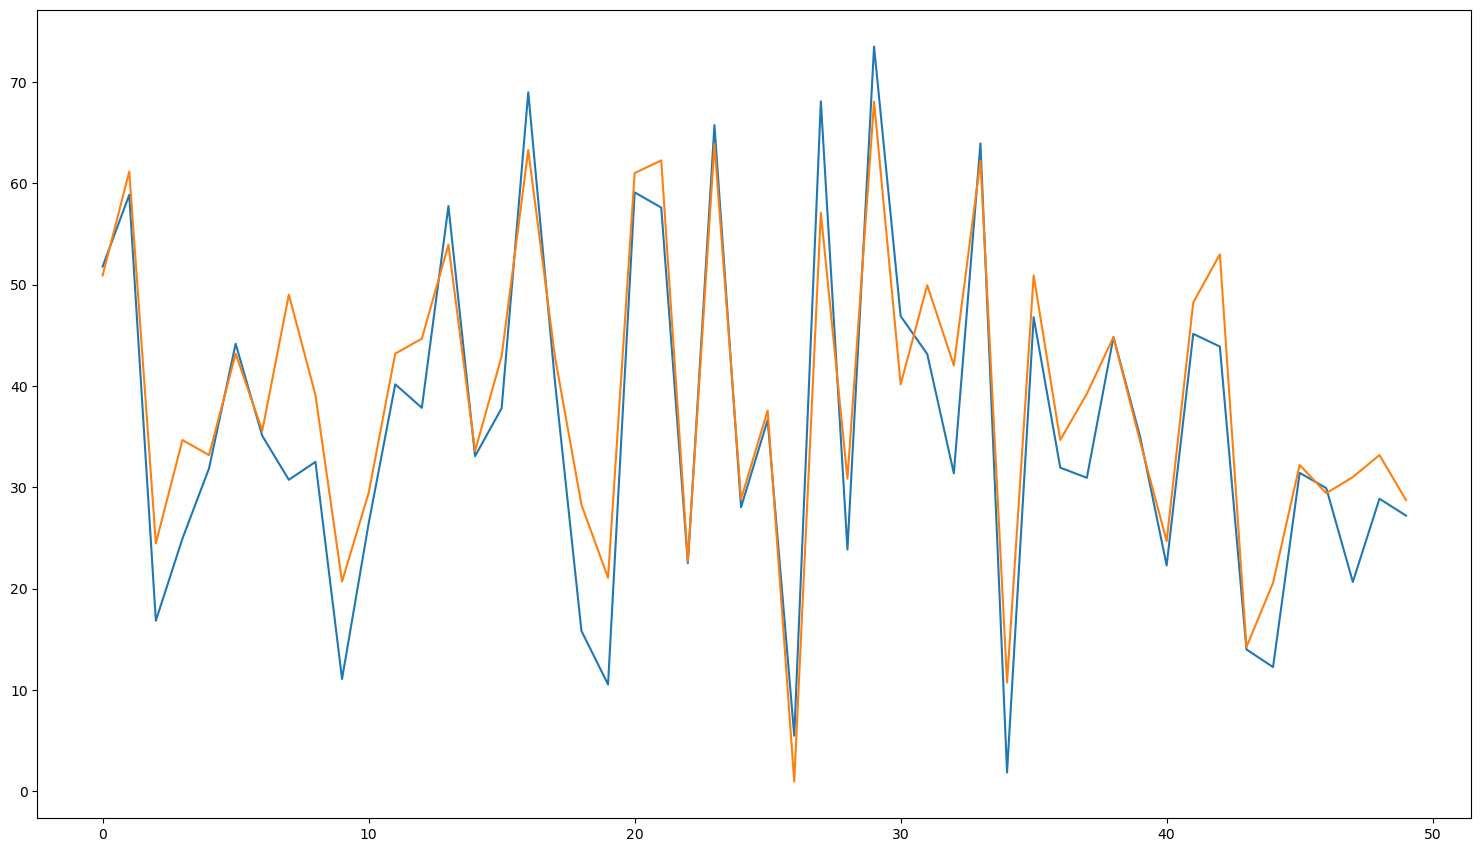

In [16]:
plt.plot(y_test[:50])
plt.plot(outputs[:50].detach())
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [19]:
from utils import get_data_pred

model.load_state_dict(torch.load("best-oat"))
out = get_data_pred('ACAvNTuEuFWcmwms', model, adjust=True)
out

tensor([[136.8534],
        [162.2755],
        [145.5975],
        [141.3932],
        [169.2242],
        [142.7644],
        [153.7741],
        [148.5941],
        [156.6452],
        [184.8379],
        [166.6174],
        [181.6385],
        [160.4877],
        [155.4698],
        [164.0909],
        [159.0375],
        [185.9217]])

<AxesSubplot:>

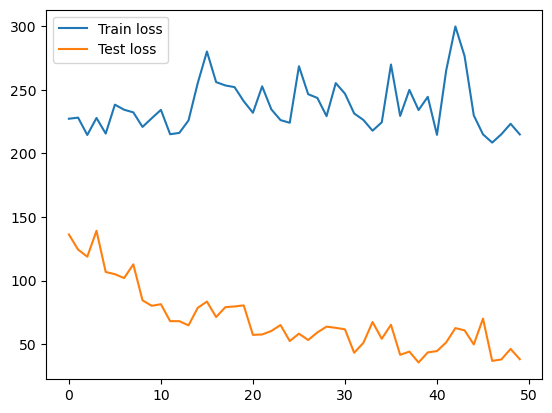

In [25]:
res = pd.DataFrame(data=np.asarray([train_losses, test_losses])).transpose()
res.columns = ['Train loss','Test loss']
res.plot()